In [154]:
import folium

colors = [
    '#b5e655',    '#b7e354',    '#bae053',    '#bcdd52',
    '#beda51',    '#c0d74f',    '#c2d44e',    '#c4d04d',
    '#c6cd4c',    '#c9ca4b',    '#cbc649',    '#cdc348',
    '#cfbf47',    '#d1bc45',    '#d3b844',    '#d5b443',
    '#d6b141',    '#d8ad40',    '#daa93e',    '#dca53d',
    '#dea13b',    '#e09c3a',    '#e29838',    '#e49336',
    '#e58f35',    '#e78a33',    '#e98531',    '#eb802f',
    '#ec7a2d',    '#ee742b',    '#f06e29',    '#f26826',
    '#f36124',    '#f55a21',    '#f7521e',    '#f84a1b',
    '#fa4018',    '#fc3413',    '#fd250e',    '#ff0000'
]
complex_group = train_df[['longitude', 'latitude', 'pricePerExclusiveArea', 'totalHouseholdCount', 'highFloor', 'lowFloor', 'completionYear', 'totalDongCount', 'maxSupplyArea', 'minSupplyArea', 'parkingCountByHousehold', 'heatMethodTypeCode', 'heatFuelTypeCode', 'address', 'complexName']].groupby(train_df['complexName']).mean().sort_values(by='pricePerExclusiveArea')

print(complex_group)


KeyError: "['completionYear', 'pricePerExclusiveArea'] not in index"

In [ ]:
print("complex_group pricePerExclusiveArea Skew: ", complex_group.pricePerExclusiveArea.skew())
print("complex_group pricePerExclusiveArea Kurtosis: %f" % complex_group.pricePerExclusiveArea.kurt())

sns.distplot(complex_group.pricePerExclusiveArea, color='green')
plt.show()

In [155]:
long = train_df['longitude'].mean()
lat = train_df['latitude'].mean()

m = folium.Map([lat,long], zoom_start=12)
for row in complex_group.values:
    sub_long = row[0]
    sub_lat =  row[1]
    price_per_sa = row[2]
    
    ratio = price_per_sa/900000
    c = colors[int(ratio)]
    #지도에 데이터 찍어서 보여주기
    folium.CircleMarker(
        [sub_lat,sub_long],
        color=c,
        fill=True,
        radius= 4
        ).add_to(m)

m

NameError: name 'complex_group' is not defined

In [1]:
import os
import math
import numpy as np 
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from scipy.stats import norm
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
plt.rcParams['font.family'] = 'AppleGothic'

In [2]:
# 파일시스템으로부터 데이터 파일 읽기
primitive_df = pd.read_csv(os.path.relpath('./train_data.csv'), index_col=0)

In [3]:
# 잉여 feature 삭제
train_df = primitive_df.drop([
            'id', 
            'exclusivePyeong', 
            'supplyPyeong', 
            'pyeongNo', 
            'complexName.1', 
            'completionMonth',
            'roadAddress.1', 
            'complexNo',
            'completionYear', 
            'rentCount', 
            'dealCount', 
            'cortarNo'], axis=1)

In [4]:
# 모든 숫자형 컬럼에 대해서 0 -> NaN으로 변경
def replaceZeroToNull(x):
    if x == 0:
        return None
    return x

numeric_cols = train_df.select_dtypes(include=[np.number]).columns.to_list()

for col in numeric_cols:
    train_df[col] = train_df[col].apply(lambda x: replaceZeroToNull(x))

# contactDate컬럼 타입 변경 (string -> Date)
train_df['contactDate'] = train_df['contactDate'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))

In [5]:
# brand열: 건설회사
def cleanBrand(raw):
    if pd.isnull(raw):
        return '기타'
    
    raw = raw.split(',')[0]
    raw = raw.split('외')[0]
    raw = raw.replace('(주)', '')
    raw = raw.replace('쭈', '')
    raw = raw.replace('(', '')
    raw = raw.replace(')', '')
    raw = raw.replace('', '')
    raw = raw.replace('M&C', '')
    raw = raw.replace('㈜', '')
    raw = raw.replace('주식회사', '')
    raw = raw.replace('주식회서', '')
    raw = raw.replace('건설', '')
    raw = raw.replace('종합', '')
    raw = raw.replace('종합', '')
    raw = raw.strip()
    raw = raw.split(' ')[0]

    return raw

train_df['brand'] = train_df['constructionCompanyName'].apply(cleanBrand)

In [6]:
# 데이터상에서 100회 이하로 언급되는 건설회사 -> 기타로 취급
brands = train_df['brand'].value_counts() > 100

noNamedBrands = []
for brand, isNamed in zip(brands.index, brands.values):
    if not isNamed:
        noNamedBrands.append(brand)
        
def extendEtc(name):
    if name in noNamedBrands:
        return '기타'
    return name

train_df['brand'] = train_df['brand'].apply(extendEtc)

train_df.drop('constructionCompanyName', axis=1, inplace=True)

In [7]:
# contactDay열: 2000년 1월 1일을 기준으로 계약일까지의 일 수
critia_date = datetime.datetime(2000, 1, 1)
def date2Mon(date):
    return (date - critia_date).days

train_df['contactDay'] = train_df['contactDate'].apply(date2Mon)
train_df.drop('contactDate', axis=1, inplace=True)

In [8]:
# volume열: 단지별 역대 거래량
volume_dict = train_df.groupby('complexName').count()['price'].to_dict()

train_df['volume'] = train_df['complexName'].apply(lambda x: volume_dict[x])

In [9]:
# floorRate열: 매물의 층과 전체 아파트 층과의 비율 
train_df['floorRate'] = train_df['floor'] / ((train_df['highFloor'] + train_df['lowFloor'])*0.8)

In [10]:
# 숫자형 컬럼
numeric_features = train_df.select_dtypes(include=[np.number])
numeric_features.dtypes

exclusiveArea               float64
price                         int64
floor                         int64
constructYear                 int64
supplyArea                  float64
householdCountByPyeong      float64
exclusiveRate               float64
roomCnt                     float64
bathroomCnt                 float64
latitude                    float64
longitude                   float64
totalHouseholdCount         float64
totalLeaseHouseholdCount    float64
highFloor                   float64
lowFloor                    float64
totalDongCount              float64
maxSupplyArea               float64
minSupplyArea               float64
batlRatio                   float64
btlRatio                    float64
parkingCountByHousehold     float64
contactDay                    int64
volume                        int64
floorRate                   float64
dtype: object

In [11]:
# 객체형 컬럼
categorical_features = train_df.select_dtypes(include=[np.object])
categorical_features.dtypes

detailAddress         object
complexName           object
roadAddress           object
realEstateTypeCode    object
entranceType          object
heatMethodTypeCode    object
heatFuelTypeCode      object
address               object
brand                 object
dtype: object

Price Skew:  3.1968312183707543
Price Kurtosis: 19.110902


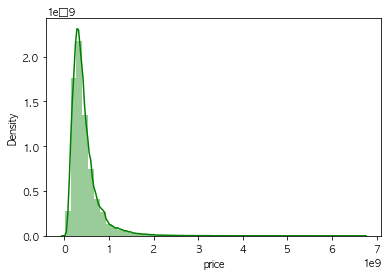

In [12]:
# 종속변수 편향도 & 첨도
print("Price Skew: ", train_df.price.skew())
print("Price Kurtosis: %f" % train_df.price.kurt())

sns.distplot(train_df.price, color='green')
plt.show()

In [13]:
# 종속변수 - 독립변수 상관관계
corr = numeric_features.corr()
print (corr['price'].sort_values(ascending=False))

price                       1.000000
supplyArea                  0.658616
exclusiveArea               0.652691
maxSupplyArea               0.570340
roomCnt                     0.501385
parkingCountByHousehold     0.452651
minSupplyArea               0.436999
bathroomCnt                 0.412517
highFloor                   0.297713
contactDay                  0.288454
exclusiveRate               0.284920
totalDongCount              0.211858
lowFloor                    0.183260
floor                       0.162933
totalHouseholdCount         0.119233
constructYear               0.104106
longitude                   0.085150
householdCountByPyeong      0.011781
floorRate                   0.010887
batlRatio                  -0.006500
volume                     -0.082593
btlRatio                   -0.100616
totalLeaseHouseholdCount   -0.178921
latitude                   -0.306248
Name: price, dtype: float64


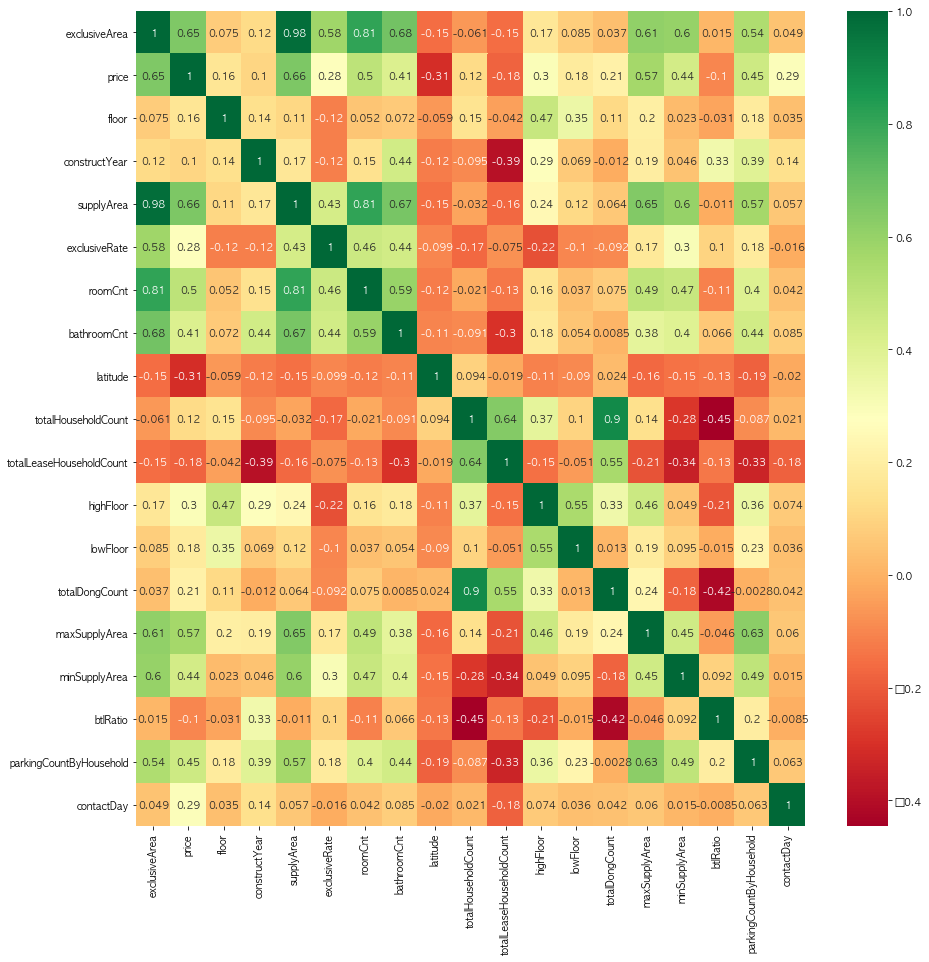

In [14]:
# 히트맵 시각화
corrmat = train_df.corr()
top_corr_features = corrmat.index[abs(corrmat['price']) > 0.1]
plt.figure(figsize=(15, 15))
g = sns.heatmap(train_df[top_corr_features].corr(), annot=True, cmap="RdYlGn")

# supplyArea와 exclusiveArea의 상관계수가 0.98으로 상관관계가 매우 높다(매우 당연하다...!)
# totalDongCount와 totalHouseholdCount의 상관계수가 0.9로 높다

In [15]:
# 상관계수가 높은 컬럼(totalHouseholdCount, exclusiveArea) 삭제
train_df.drop(['totalHouseholdCount', 'exclusiveArea'], axis=1, inplace=True)

In [16]:
# 컬럼별 결측치 비율
train_df.isnull().sum()/train_df.shape[0]*100

detailAddress                0.000000
complexName                  0.000000
price                        0.000000
floor                        0.000000
constructYear                0.000000
roadAddress                  0.000000
supplyArea                   0.000000
householdCountByPyeong       0.001893
realEstateTypeCode           0.000000
exclusiveRate                0.000000
entranceType                 0.000000
roomCnt                      0.021202
bathroomCnt                  0.021202
latitude                     0.000000
longitude                    0.000000
totalLeaseHouseholdCount    92.379860
highFloor                    0.000000
lowFloor                     0.000000
totalDongCount               0.001262
maxSupplyArea                0.000000
minSupplyArea                0.009844
batlRatio                    4.918051
btlRatio                    10.493610
parkingCountByHousehold      4.659718
heatMethodTypeCode           0.042908
heatFuelTypeCode             0.040384
address     

In [17]:
# 결측치가 너무 많은 totalLeaseHouseholdCount, btlRatio, parkingCountByHousehold, batlRatio열 삭제
train_df.drop(['totalLeaseHouseholdCount', 'btlRatio', 'parkingCountByHousehold', 'batlRatio'], axis=1, inplace=True)

In [18]:
# 레코드 중 NaN이 있는 레코드 개수(False)
(train_df.isnull().sum(1) == 0).value_counts()

True     791456
False       931
dtype: int64

In [19]:
# 결측값이 있는 행 삭제
train_df.dropna(inplace=True)

In [20]:
# 컬럼별 결측값 개수
train_df.isnull().sum()

# 결측값이 모두 제거됨

detailAddress             0
complexName               0
price                     0
floor                     0
constructYear             0
roadAddress               0
supplyArea                0
householdCountByPyeong    0
realEstateTypeCode        0
exclusiveRate             0
entranceType              0
roomCnt                   0
bathroomCnt               0
latitude                  0
longitude                 0
highFloor                 0
lowFloor                  0
totalDongCount            0
maxSupplyArea             0
minSupplyArea             0
heatMethodTypeCode        0
heatFuelTypeCode          0
address                   0
brand                     0
contactDay                0
volume                    0
floorRate                 0
dtype: int64

In [21]:
# 데이터 처리 후 상관관계
numeric_features = train_df.select_dtypes(include=[np.number])
corr = numeric_features.corr()
print (corr['price'].sort_values(ascending=False))

price                     1.000000
supplyArea                0.658869
maxSupplyArea             0.570246
roomCnt                   0.501339
minSupplyArea             0.437300
bathroomCnt               0.412446
highFloor                 0.297595
contactDay                0.288407
exclusiveRate             0.284382
totalDongCount            0.211806
lowFloor                  0.183092
floor                     0.162881
constructYear             0.104326
longitude                 0.085169
householdCountByPyeong    0.011695
floorRate                 0.010956
volume                   -0.082662
latitude                 -0.306036
Name: price, dtype: float64


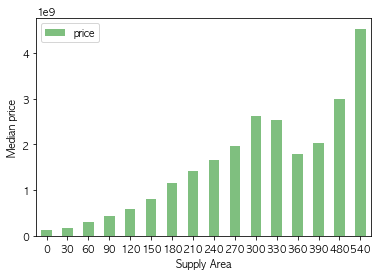

In [22]:
train_df['supplyAreaRange'] = train_df['supplyArea'].apply(lambda x: int(x/30)*30)
quality_pivot = train_df.pivot_table(index='supplyAreaRange', values='price', aggfunc=np.median)
quality_pivot.plot(kind='bar', color='green', alpha = 0.5)
plt.xlabel('Supply Area')
plt.ylabel('Median price')
plt.xticks(rotation=0)
plt.show()

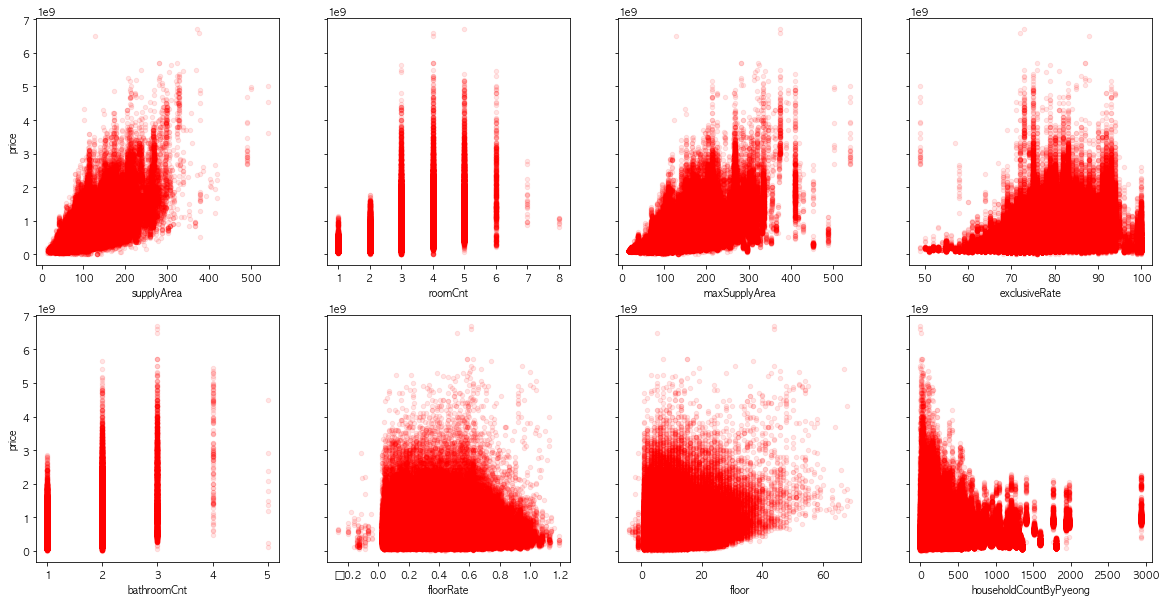

In [23]:
# 주요 컬럼 시각화
fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(20, 10))
axes = np.ravel(axes)
col_name = ['supplyArea','roomCnt','maxSupplyArea','exclusiveRate', 'bathroomCnt', 'floorRate', 'floor', 'householdCountByPyeong']
for i, c in zip(range(len(col_name)), col_name):
    train_df.plot.scatter(ax=axes[i], x=c, y='price', sharey=True, colorbar=False, color='red', alpha = 0.1)   

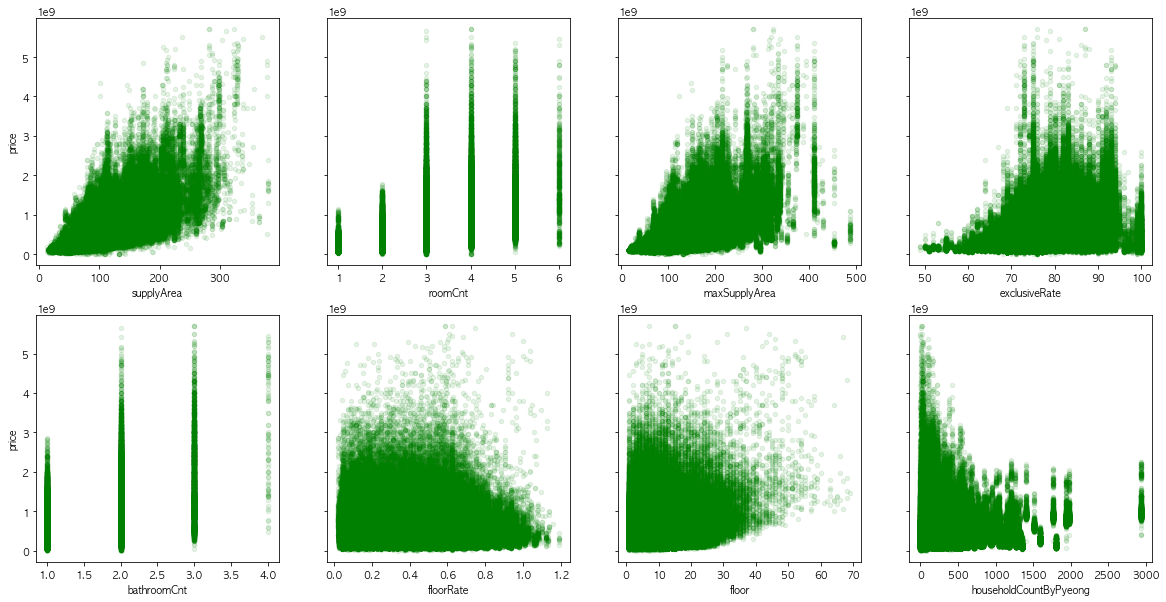

In [24]:
# 이상치 제거
train_df = train_df[train_df['price'] < 6000000000]
train_df = train_df[train_df['supplyArea'] < 450]
train_df = train_df[train_df['roomCnt'] < 7]
train_df = train_df[train_df['maxSupplyArea'] < 500]
train_df = train_df[(train_df['exclusiveRate']>60) | (train_df['price']<1000000000)]
train_df = train_df[train_df['bathroomCnt'] < 5]
train_df = train_df[train_df['floorRate'] >= 0]

fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(20, 10))
axes = np.ravel(axes)
for i, c in zip(range(len(col_name)), col_name):
    train_df.plot.scatter(ax=axes[i], x=c, y='price', sharey=True, colorbar=False, color='green', alpha = 0.1)   

In [25]:
# 카테고리형 컬럼 
categoricals = train_df.select_dtypes(exclude=[np.number])

for c in categoricals.columns:
    print('{:<14}'.format(c), train_df[c].unique())

detailAddress  ['713' '655-2' '658-1' ... '51-11' '1546' '1005']
complexName    ['브라운스톤방학아파트' '개포2차현대아파트(220)' '개포6차우성아파트1동~8동' ... '하니맨션' '(1546-0)'
 '(578-5)201호 미공시']
roadAddress    ['도봉로146길 36' '언주로 103' '언주로 3' ... '난계로15길 36-6' '난계로13길 36' '망우로 297']
realEstateTypeCode ['A01' 'A03']
entranceType   ['계단식' '복도식' '복합식']
heatMethodTypeCode ['HT001' 'HT002' 'HT005' 'HT003']
heatFuelTypeCode ['HF001' 'HF002' 'HF004' 'HF007' 'HF003']
address        ['서울시 도봉구 방학동' '서울시 강남구 개포동' '서울시 강남구 논현동' '서울시 강남구 대치동' '서울시 강남구 도곡동'
 '서울시 강남구 삼성동' '서울시 강남구 세곡동' '서울시 강남구 수서동' '서울시 강남구 신사동' '서울시 강남구 압구정동'
 '서울시 강남구 역삼동' '서울시 강남구 일원동' '서울시 강남구 자곡동' '서울시 강남구 청담동' '서울시 강동구 강일동'
 '서울시 강동구 고덕동' '서울시 강동구 길동' '서울시 강동구 둔촌동' '서울시 강동구 명일동' '서울시 강동구 상일동'
 '서울시 강동구 성내동' '서울시 강동구 암사동' '서울시 강동구 천호동' '서울시 강북구 미아동' '서울시 강북구 번동'
 '서울시 강북구 수유동' '서울시 강북구 우이동' '서울시 강서구 가양동' '서울시 강서구 공항동' '서울시 강서구 내발산동'
 '서울시 강서구 등촌동' '서울시 강서구 마곡동' '서울시 강서구 방화동' '서울시 강서구 염창동' '서울시 강서구 화곡동'
 '서울시 관악구 남현동' '서울시 관악구 봉천동' '서울시 관악구 신림동' '서울시 광진

In [26]:
# 학습에 쓸모없는 열 삭제
train_df.drop(['detailAddress', 'complexName', 'roadAddress'], axis=1, inplace=True)

In [27]:
# 카테고리형 컬럼 원핫인코딩
columns = train_df.select_dtypes(exclude=[np.number]).columns

for c in columns:
    oh_df = pd.get_dummies(train_df[c])
    train_df = pd.concat([train_df, oh_df], axis=1)
    train_df.drop(c, axis=1)

train_df.shape

(791248, 781)

In [28]:
# 원핫인코딩한 열 삭제
train_df.drop(columns, axis=1, inplace=True)

In [29]:
# 피처/레이블 분리
X = train_df.drop('price', axis=1)
y = train_df['price']

In [30]:
# 학습/테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,  random_state =1)

In [31]:
# RandomForest
random_forest_regressor = RandomForestRegressor(n_estimators=100, n_jobs=-1)
random_forest_regressor = random_forest_regressor.fit(X_train, y_train)

y_pred_rf = random_forest_regressor.predict(X_test)
print('The accuracy of the Random Forset is', r2_score(y_test,y_pred_rf))
print ('RMSE is: ', mean_squared_error(y_test, y_pred_rf)**0.5)
print('\n')

The accuracy of the Random Forset is 0.9814871229970229
RMSE is:  44348231.24317671




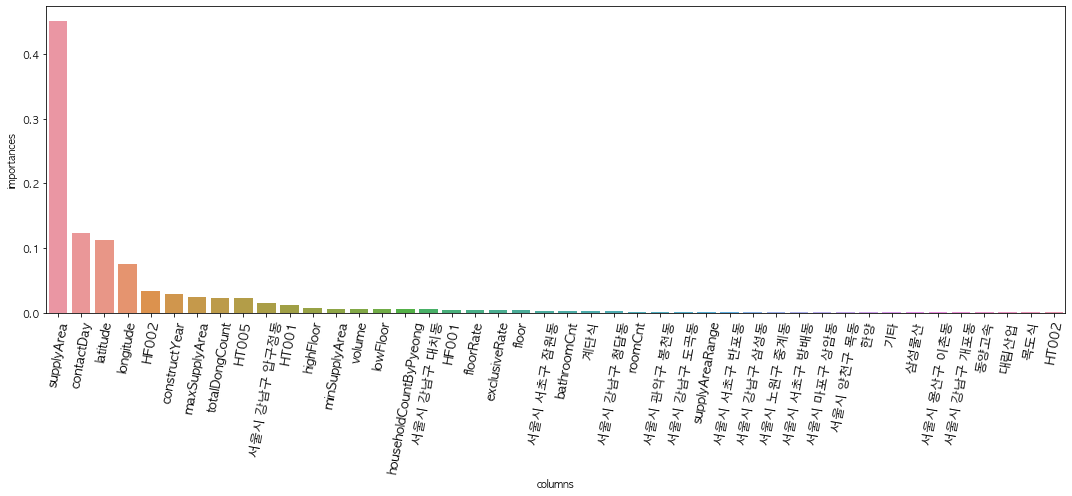

In [32]:
# 피처 중요도
feature_importance = random_forest_regressor.feature_importances_

df_fi = pd.DataFrame({'columns':X_train.columns, 'importances':feature_importance})
df_fi = df_fi[df_fi['importances'] > 0.0003] # importance가 0.0001이상인 것만 
df_fi = df_fi.sort_values(by=['importances'], ascending=False)

fig = plt.figure(figsize=(15,7))
ax = sns.barplot(df_fi['columns'], df_fi['importances'])
ax.set_xticklabels(df_fi['columns'], rotation=80, fontsize=13)
plt.tight_layout()
plt.show()

In [33]:
# 중요도가 0.00005 이상인 열만 추출
importantFeatures = df_fi[df_fi['importances'] > 0.0003]['columns'].to_list()

train_df_fi = train_df[importantFeatures]

print(len(importantFeatures))

44


In [34]:
# 학습/테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(train_df_fi, y, test_size = 0.2,  random_state =1)

In [129]:
# RandomForest
random_forest_regressor = RandomForestRegressor(n_estimators=100, n_jobs=-1)
random_forest_regressor = random_forest_regressor.fit(X_train, y_train)

y_pred_rf = random_forest_regressor.predict(X_test)
print('The accuracy of the Random Forset is', r2_score(y_test,y_pred_rf))
print ('RMSE is: ', mean_squared_error(y_test, y_pred_rf)**0.5)
print('\n')

The accuracy of the Random Forset is 0.981313060668756
RMSE is:  44556229.61088345




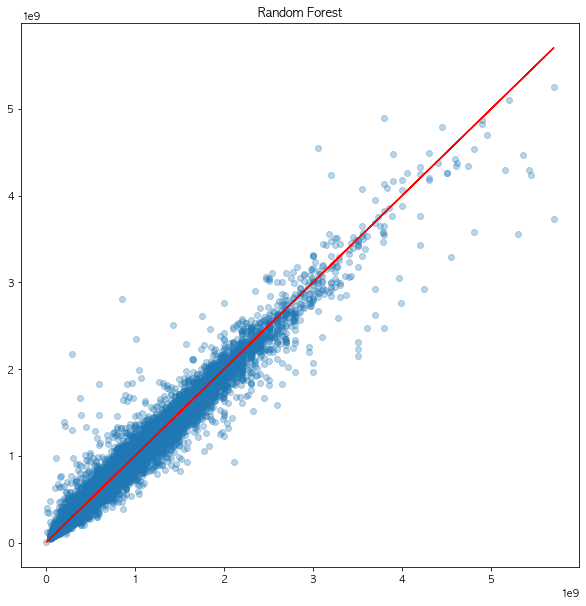

In [58]:
# Random Forest Result Visualization
fig = plt.figure(figsize=(10,10))
plt.scatter(y_test,y_pred_rf, alpha=0.3)
plt.plot(y_test,y_test,'r')
plt.title('Random Forest')
plt.show()

In [132]:
# DecisionTree
decision_tree_regressor = DecisionTreeRegressor(max_depth=24, random_state=0)
decision_tree_regressor = decision_tree_regressor.fit(X_train, y_train)
y_pred_dt = decision_tree_regressor.predict(X_test)

print('The accuracy of the Decision Tree is',r2_score(y_test,y_pred_dt))
print ('RMSE is: ', mean_squared_error(y_test, y_pred_dt)**0.5)
print('\n')

The accuracy of the Decision Tree is 0.9662223439802233
RMSE is:  59903762.35757999




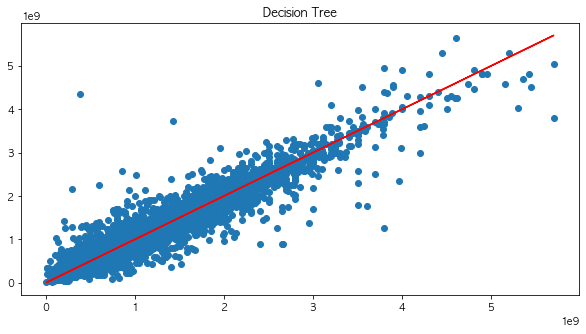

In [136]:
# Decision Tree Result Visualization
fig = plt.figure(figsize=(10,5))
plt.scatter(y_test,y_pred_dt)
plt.plot(y_test,y_test,'r')
plt.title('Decision Tree')
plt.show()

In [135]:
# XGBoost
xgboost_regressor = XGBRegressor(max_depth=13)
xgboost_regressor = xgboost_regressor.fit(X_train, y_train)

y_pred_xgb = xgboost_regressor.predict(X_test)
print('The accuracy of the XGBoost is', r2_score(y_test,y_pred_xgb))
print ('RMSE is: ', mean_squared_error(y_test, y_pred_xgb)**0.5)
print('\n')

The accuracy of the XGBoost is 0.9812544539115751
RMSE is:  44626044.465896696




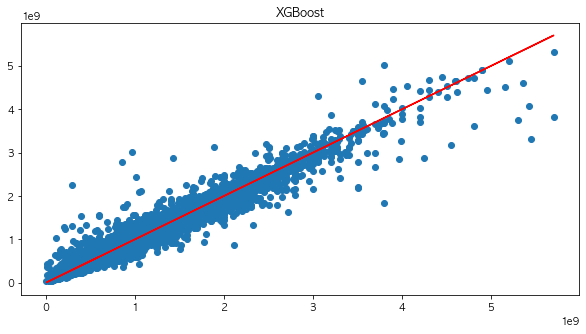

In [138]:
# XGBoost Result Visualization
fig = plt.figure(figsize=(10,5))
plt.scatter(y_test,y_pred_xgb)
plt.plot(y_test,y_test,'r')
plt.title('XGBoost')
plt.show()

In [ ]:
#support vector marchine
svm_reg = SVR(epsilon=0.01, gamma=1, C=100)
svm_reg.fit(X_train, y_train)

y_pred_svm = svm_reg.predict(X_test)
print('The accuracy of SVM is',r2_score(y_test,y_pred_svm))
print ('RMSE is: ', mean_squared_error(y_test, y_pred_svm)**0.5)

In [52]:
# Neural Network Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

X_train.shape

(632998, 44)

In [42]:
model = Sequential()
model.add(Dense(44,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(1))

model.compile(optimizer='Adam',loss='mse')

In [53]:
model = tf.keras.models.load_model('layer.h5')
model.fit(x=X_train,y=y_train,
          validation_data=(X_test,y_test),
          batch_size=128,epochs=200)
model.summary()

model.save('layer.h5')

Epoch 1/200
4946/4946 [==============================] - 10s 2ms/step - loss: 5003934326325248.0000 - val_loss: 5122609641422848.0000
Epoch 2/200
4946/4946 [==============================] - 10s 2ms/step - loss: 4982853016223744.0000 - val_loss: 5047842313863168.0000
Epoch 3/200
4946/4946 [==============================] - 10s 2ms/step - loss: 4896184871157760.0000 - val_loss: 5420273960484864.0000
Epoch 4/200
4946/4946 [==============================] - 10s 2ms/step - loss: 5126730125672448.0000 - val_loss: 5319214453751808.0000
Epoch 5/200
4946/4946 [==============================] - 10s 2ms/step - loss: 4736674080751616.0000 - val_loss: 5142951680278528.0000
Epoch 6/200
4946/4946 [==============================] - 11s 2ms/step - loss: 4808847248064512.0000 - val_loss: 4620757208399872.0000
Epoch 7/200
4946/4946 [==============================] - 11s 2ms/step - loss: 4815560818819072.0000 - val_loss: 5200193930657792.0000
Epoch 8/200
4946/4946 [==============================] - 10s 2

Epoch 62/200
4946/4946 [==============================] - 12s 2ms/step - loss: 3434095862349824.0000 - val_loss: 4271695284142080.0000
Epoch 63/200
4946/4946 [==============================] - 12s 2ms/step - loss: 3462256352296960.0000 - val_loss: 3553018943373312.0000
Epoch 64/200
4946/4946 [==============================] - 11s 2ms/step - loss: 3382954344579072.0000 - val_loss: 3770612455571456.0000
Epoch 65/200
4946/4946 [==============================] - 12s 2ms/step - loss: 3420619865587712.0000 - val_loss: 3538203185250304.0000
Epoch 66/200
4946/4946 [==============================] - 11s 2ms/step - loss: 3445979499986944.0000 - val_loss: 3486042149617664.0000
Epoch 67/200
4946/4946 [==============================] - 11s 2ms/step - loss: 3494900519665664.0000 - val_loss: 3764374820880384.0000
Epoch 68/200
4946/4946 [==============================] - 12s 2ms/step - loss: 3296084067614720.0000 - val_loss: 3884534315614208.0000
Epoch 69/200
4946/4946 [==============================]

4946/4946 [==============================] - 12s 2ms/step - loss: 2797894436388864.0000 - val_loss: 4475644758982656.0000
Epoch 123/200
4946/4946 [==============================] - 11s 2ms/step - loss: 2927916518211584.0000 - val_loss: 3191557180096512.0000
Epoch 124/200
4946/4946 [==============================] - 11s 2ms/step - loss: 2798212800839680.0000 - val_loss: 3315747501637632.0000
Epoch 125/200
4946/4946 [==============================] - 11s 2ms/step - loss: 2839133638623232.0000 - val_loss: 3156975177170944.0000
Epoch 126/200
4946/4946 [==============================] - 11s 2ms/step - loss: 2774415460794368.0000 - val_loss: 3065830870876160.0000
Epoch 127/200
4946/4946 [==============================] - 12s 2ms/step - loss: 2820610518417408.0000 - val_loss: 3275798937075712.0000
Epoch 128/200
4946/4946 [==============================] - 11s 2ms/step - loss: 2797792699351040.0000 - val_loss: 4043895319035904.0000
Epoch 129/200
4946/4946 [==============================] - 11s

4946/4946 [==============================] - 10s 2ms/step - loss: 2531813427773440.0000 - val_loss: 4052339224739840.0000
Epoch 183/200
4946/4946 [==============================] - 10s 2ms/step - loss: 2506490569031680.0000 - val_loss: 3025234303123456.0000
Epoch 184/200
4946/4946 [==============================] - 10s 2ms/step - loss: 2438514926944256.0000 - val_loss: 3451495311736832.0000
Epoch 185/200
4946/4946 [==============================] - 10s 2ms/step - loss: 2531151734374400.0000 - val_loss: 2872060736962560.0000
Epoch 186/200
4946/4946 [==============================] - 10s 2ms/step - loss: 2505638018023424.0000 - val_loss: 3077059526000640.0000
Epoch 187/200
4946/4946 [==============================] - 10s 2ms/step - loss: 2472961906835456.0000 - val_loss: 3152431101771776.0000
Epoch 188/200
4946/4946 [==============================] - 10s 2ms/step - loss: 2470740871872512.0000 - val_loss: 3227688860909568.0000
Epoch 189/200
4946/4946 [==============================] - 10s

In [54]:
y_pred_nn = model.predict(X_test)
print('The accuracy of the Nerual Network is', r2_score(y_test,y_pred_nn))
print ('RMSE is: ', mean_squared_error(y_test, y_pred_nn)**0.5)

The accuracy of the Nerual Network is 0.9713074567351634
RMSE is:  55210778.13686289


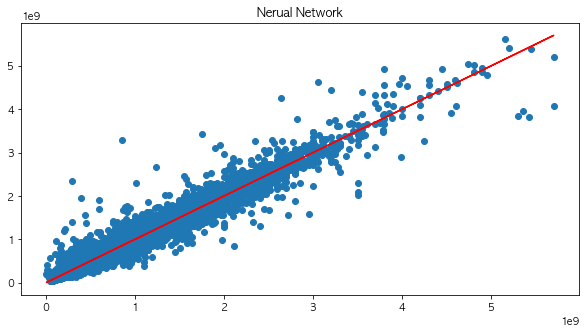

In [55]:
# Nerual Network Result Visualization
fig = plt.figure(figsize=(10,5))
plt.scatter(y_test,y_pred_nn)
plt.plot(y_test,y_test,'r')
plt.title('Nerual Network')
plt.show()